<a href="https://colab.research.google.com/github/vimaldaspv/Computer-Vision-and-Artificial-Intelligence---Practical-skills-assessment/blob/main/Computer_Vision_and_Artificial_Intelligence_Practical_skills_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the required tools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import os
import pandas as pd

#Setting the Dataset Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Defining dataset path
data_file = '/content/drive/MyDrive/PlantVillage'

# Checking the subfolders
print("Disease categories:", os.listdir(data_file))

Mounted at /content/drive
Disease categories: ['Potato___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Bacterial_spot', 'Pepper__bell___healthy']


#Dataset Preparation with Image Augmentation and Splitting

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Train-Validation splitting utilizing the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
        data_file,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
val_generator = train_datagen.flow_from_directory(
        data_file,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

# Showing the Number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Found 3805 images belonging to 4 classes.
Found 949 images belonging to 4 classes.
Number of classes: 4


#Implementing the Model Architecture (CNN)

In [ ]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,956 (24.86 MB)

 Trainable params: 6,517,508 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

#Compiling and Training the Model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7733 - loss: 3.2968 

119/119 ━━━━━━━━━━━━━━━━━━━━ 2320s 19s/step - accuracy: 0.7737 - loss: 3.2860 - val_accuracy: 0.4478 - val_loss: 66.9063
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - accuracy: 0.8595 - loss: 0.5660 - val_accuracy: 0.4478 - val_loss: 98.5471
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step - accuracy: 0.8759 - loss: 0.3551 - val_accuracy: 0.4478 - val_loss: 72.2883
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9097 - loss: 0.3079

119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 323ms/step - accuracy: 0.9097 - loss: 0.3079 - val_accuracy: 0.6091 - val_loss: 9.7807
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 323ms/step - accuracy: 0.8930 - loss: 0.3241 - val_accuracy: 0.5216 - val_loss: 20.0759
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9165 - loss: 0.3114

119/119 ━━━━━━━━━━━━━━━━━━━━ 34s 289ms/step - accuracy: 0.9164 - loss: 0.3117 - val_accuracy: 0.5606 - val_loss: 4.4394
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8927 - loss: 0.3451

119/119 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.8928 - loss: 0.3447 - val_accuracy: 0.7503 - val_loss: 2.0006
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9313 - loss: 0.2747

119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 325ms/step - accuracy: 0.9313 - loss: 0.2744 - val_accuracy: 0.8714 - val_loss: 0.6963
Epoch 9/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.9467 - loss: 0.1901 - val_accuracy: 0.8925 - val_loss: 0.7125
Epoch 10/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 293ms/step - accuracy: 0.9380 - loss: 0.2166 - val_accuracy: 0.8451 - val_loss: 1.3106


# Visualizing the Training Results

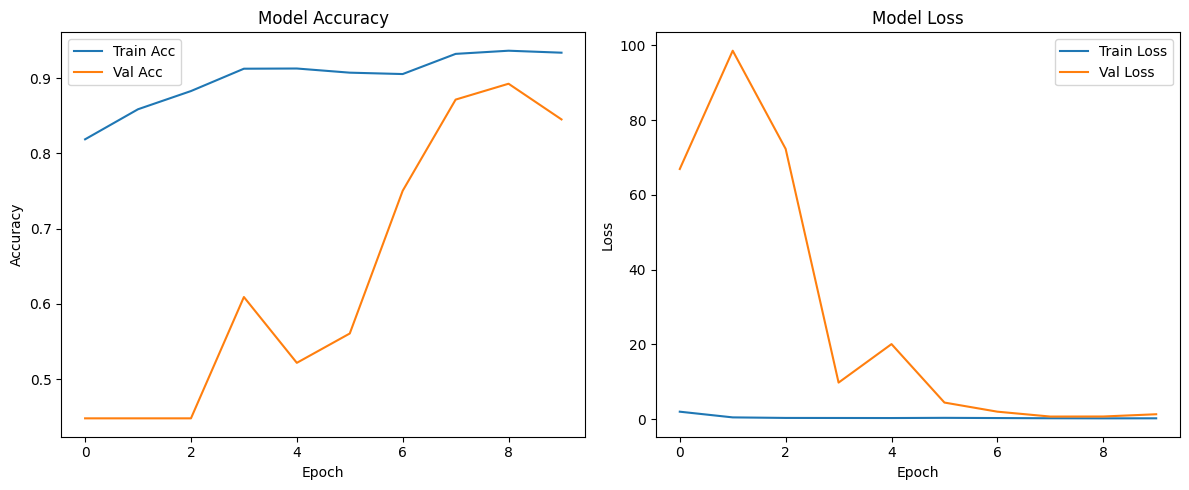

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Evaluating the Model Performance

In [ ]:
# Predict on validation set
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes

# Get the mapping from class index to class label used in the validation generator
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
actual_labels = [idx_to_class[i] for i in sorted(set(true_classes))]

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_classes, predicted_classes, target_names=actual_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.99      0.59      0.74       199
       Pepper__bell___healthy       0.72      1.00      0.84       295
             Potato___healthy       1.00      0.03      0.06        30
        Tomato_Bacterial_spot       0.98      0.97      0.98       425

                     accuracy                           0.87       949
                    macro avg       0.92      0.65      0.65       949
                 weighted avg       0.90      0.87      0.86       949

Confusion Matrix:
 [[118  75   0   6]
 [  1 294   0   0]
 [  0  28   1   1]
 [  0  12   0 413]]


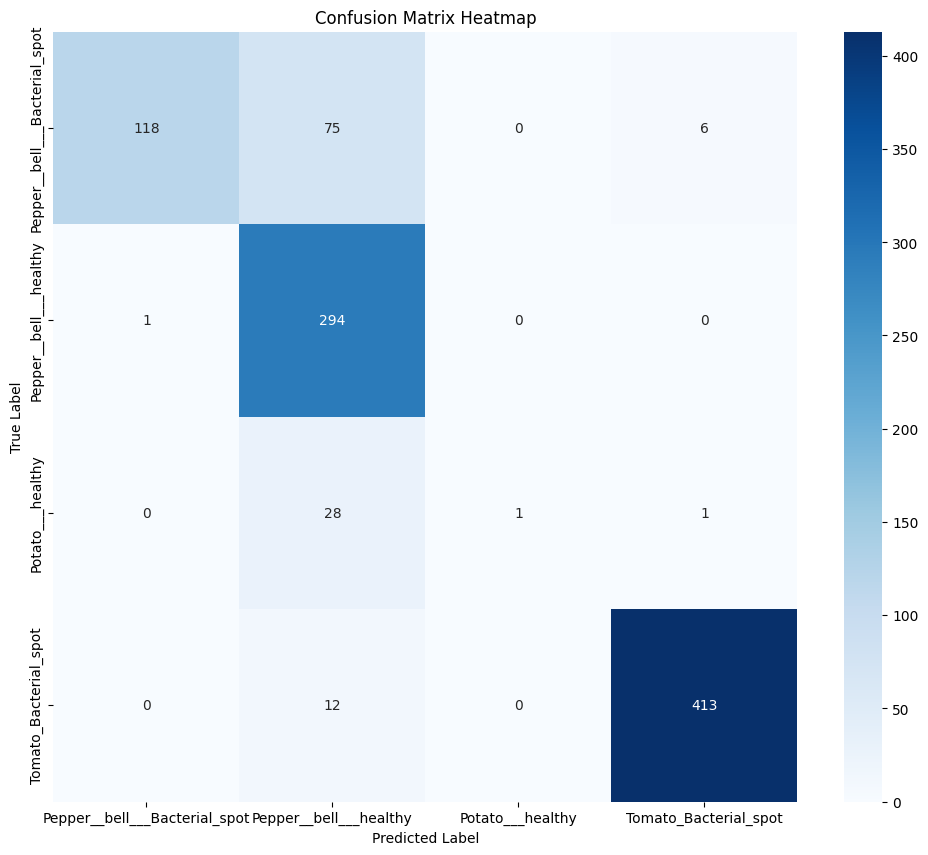

In [ ]:
import seaborn as sns
# Get the class labels
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
actual_labels = [idx_to_class[i] for i in sorted(set(true_classes))]


# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=actual_labels, yticklabels=actual_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

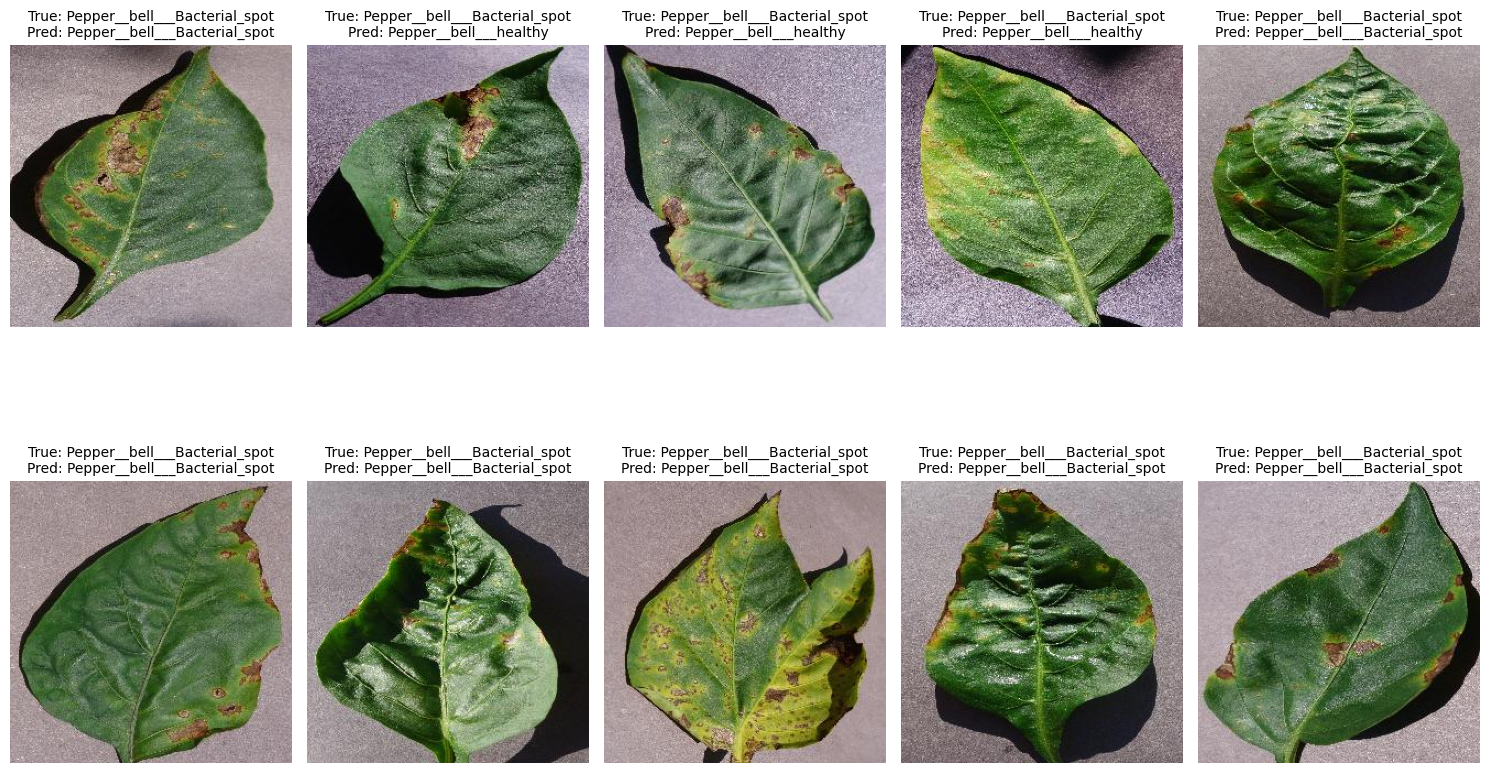

In [ ]:
# Number of samples to display
num_images = 10

# Obtaining the filenames from the generator
filenames = val_generator.filenames
class_indices = val_generator.class_indices
idx_to_label = {v: k for k, v in class_indices.items()}

# Plot the first few images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images):
    # Loading image from directory
    img_path = val_generator.directory + '/' + filenames[i]
    img = plt.imread(img_path)

    # True and predicted labels
    true_label = idx_to_label[true_classes[i]]
    predicted_label = idx_to_label[predicted_classes[i]]

    # Plotting
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

<ipython-input-20-d6030365e9d1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Image_Count', y='Class', data=df_classes, palette='viridis')


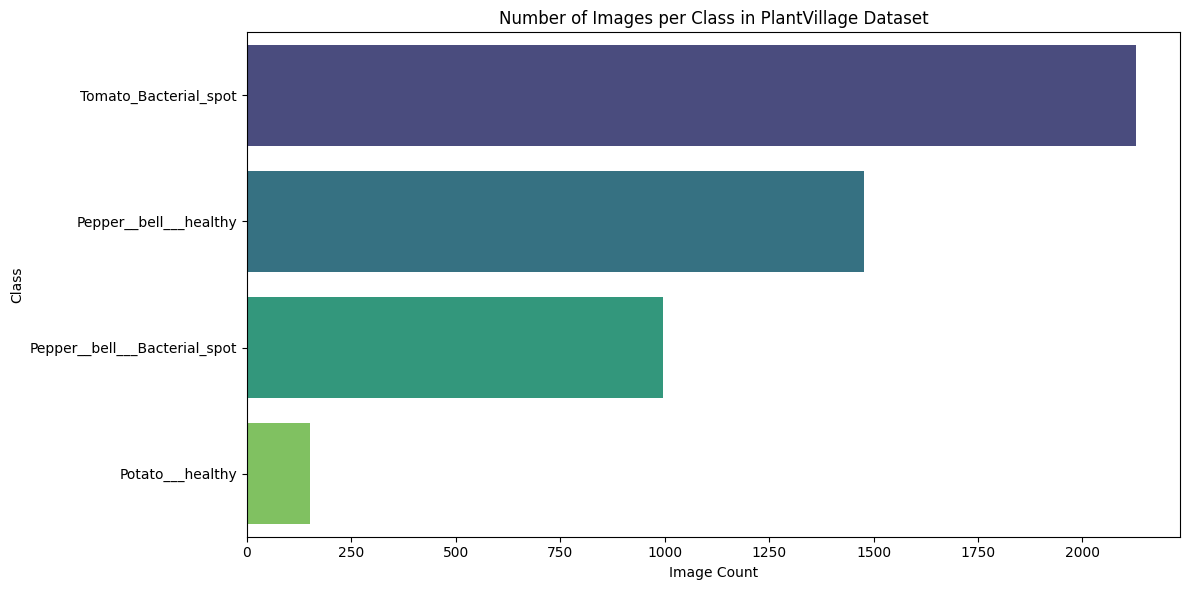

In [ ]:
# Obtaining dataset directory
base_dir = train_generator.directory  # same directory used for ImageDataGenerator

# Count images per class
class_counts = {}
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = len(os.listdir(class_path))

# Converting to DataFrame
df_classes = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image_Count'])
df_classes = df_classes.sort_values(by='Image_Count', ascending=False)

# Showing the Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Image_Count', y='Class', data=df_classes, palette='viridis')
plt.title('Number of Images per Class in PlantVillage Dataset')
plt.xlabel('Image Count')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

In [ ]:
# Showing top 10 classes with most images
df_classes.head(10)

,Class,Image_Count
2,Tomato_Bacterial_spot,2127
3,Pepper__bell___healthy,1478
1,Pepper__bell___Bacterial_spot,997
0,Potato___healthy,152
